In [1]:
from pyaudi import gdual
from pyaudi import sin, cos, tanh, exp, log
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Newton's method to train a neural network:

    Inputs: 3
    Hidden layers: 2 with 5 units/layer
    Outputs: 1

We need derivatives up to order 1

In [347]:
n_inputs = 8
order = 2

Create symbolic variables for the weights, initialized to $\mathcal N(0,0.1)$

In [348]:
def initialize_weights(n_inputs, order):

    weights = []
    for unit in range(n_inputs+1):
                symname = 'w_{{{0}}}'.format(unit)
                w = gdual(np.random.randn(), symname , order)
                weights.append(w)
          
    return weights

weights = initialize_weights(n_inputs,order)

In [349]:
def sig(x):
    return 1/(1+exp(-1*x))

Create a function which output is the symbolic expression of the neural network

In [350]:
def logistic_regression_f(inputs, w):
    
    unit_output = w[0]
    for unit in range(len(weights)-1):
        unit_output += inputs[unit]*weights[unit+1]           
    return sig(unit_output)

Define symbolic variables for the inputs and compute the (random) output of the network

In [351]:
x = [1,2,3,4,5,6,7,8]

N = logistic_regression_f(x, weights)
print('N(x) = {0}'.format(N.constant_cf))
N

N(x) = 3.723500219058739e-12


2.2341e-11*dw_{6}+7.81935e-11*dw_{3}*dw_{7}+1.78728e-10*dw_{6}*dw_{8}+1.56387e-10*dw_{6}*dw_{7}+8.9364e-11*dw_{3}*dw_{8}+1.11705e-11*dw_{3}+1.11705e-11*dw_{0}*dw_{3}+2.2341e-11*dw_{1}*dw_{6}+1.4894e-11*dw_{0}*dw_{4}+2.2341e-11*dw_{0}*dw_{6}+5.58525e-11*dw_{3}*dw_{5}+3.7235e-12*dw_{0}*dw_{1}+5.2129e-11*dw_{2}*dw_{7}+1.04258e-10*dw_{4}*dw_{7}+7.447e-12*dw_{1}*dw_{2}+7.447e-12*dw_{2}+1.4894e-11*dw_{4}+5.9576e-11*dw_{2}*dw_{8}+1.19152e-10*dw_{4}*dw_{8}+7.447e-11*dw_{4}*dw_{5}+...

The desired output of the network is: $y(\mathcal x)= x_1x_2 + 0.5x_3 +2$

In [352]:
def vis_proj(x):
    x = np.asarray(x)
    x = x.reshape(-1,n_inputs)
    proj_ws = np.asarray([[0,1,-0.5,-1,2,1,-0.5,1], [1,0.5,1,0.5,-1,0,2,-1]]).transpose()
    return np.dot(x,proj_ws)
    

In [353]:
def y_f(x):
    x = vis_proj(x)    
    ws = np.asarray([1,0.4]).reshape(2,1)
    y = np.sum(np.dot(x, ws),1)
    
    y[y>0] = 1
    y[y<0] = 0
    return y

y = y_f(x)
print('y = {0}'.format(y))

y = [ 1.]


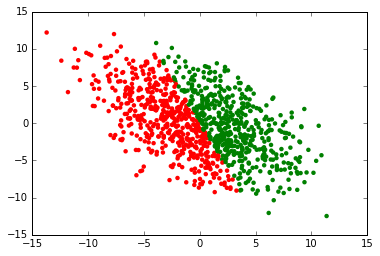

In [354]:
X = np.random.rand(1000, n_inputs)*5-2.5
X_vis = vis_proj(X)

for i in range(X.shape[0]):
    if y_f(X[i,:]) == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
        

And the training process will seek to minimize a loss function corresponding to the quadratic error

In [355]:
def loss_f(N,y):
    if N.constant_cf==0 or N.constant_cf==1:        
        if N.constant_cf==y:
            return N*0
        else:
            return N/N          
    return -1*((N)**y+(1-N)**(1-y))

loss = loss_f(N, y)
print('loss = {0}'.format(loss.constant_cf))
loss

loss = -1.0000000000037235


-2.2341e-11*dw_{6}-7.81935e-11*dw_{3}*dw_{7}-1.78728e-10*dw_{6}*dw_{8}-1.56387e-10*dw_{6}*dw_{7}-8.9364e-11*dw_{3}*dw_{8}-1.11705e-11*dw_{3}-1.11705e-11*dw_{0}*dw_{3}-2.2341e-11*dw_{1}*dw_{6}-1.4894e-11*dw_{0}*dw_{4}-2.2341e-11*dw_{0}*dw_{6}-5.58525e-11*dw_{3}*dw_{5}-3.7235e-12*dw_{0}*dw_{1}-5.2129e-11*dw_{2}*dw_{7}-1.04258e-10*dw_{4}*dw_{7}-7.447e-12*dw_{1}*dw_{2}-7.447e-12*dw_{2}-1.4894e-11*dw_{4}-5.9576e-11*dw_{2}*dw_{8}-1.19152e-10*dw_{4}*dw_{8}-7.447e-11*dw_{4}*dw_{5}+...

In [356]:
def GD_update(loss, w, lr):
    
    for i in range(len(w)):
                wi = w[i]
                if wi.symbol_set[0] in loss.symbol_set:
                    idx = loss.symbol_set.index(wi.symbol_set[0])
                    dw_idx = [0]*loss.symbol_set_size                    
                    dw_idx[idx] = 1
                    w[i] -= loss.get_derivative(dw_idx) * lr
    return w

In [369]:
weights = initialize_weights(n_inputs, order)                

In [370]:
X_train = np.random.rand(400,n_inputs)*5-2.5


In [371]:
epochs = 20

for e in range(epochs):
    
        
    #Meassures the train accuracy
    acc = 0
    for xi in X_train:
        N = logistic_regression_f(xi, weights)
        pred = N.constant_cf
        if pred > 0.5:
            pred = 1
        else:
            pred = 0
        if pred == y_f(xi):
            acc += 1/X_train.shape[0]            
    print('Epoch {0}: accuracy {1}'.format(e, acc))    

    #Updates the weights
    for xi in X_train:
        N = logistic_regression_f(xi, weights)
        loss = loss_f(N, y_f(xi))           
        weights = GD_update(loss, weights, 0.1)    


Epoch 0: accuracy 0.515
Epoch 1: accuracy 0.8149999999999936
Epoch 2: accuracy 0.9474999999999908
Epoch 3: accuracy 0.9749999999999902
Epoch 4: accuracy 0.9874999999999899
Epoch 5: accuracy 0.9899999999999899
Epoch 6: accuracy 0.9874999999999899
Epoch 7: accuracy 0.9874999999999899
Epoch 8: accuracy 0.9899999999999899
Epoch 9: accuracy 0.9899999999999899
Epoch 10: accuracy 0.9899999999999899
Epoch 11: accuracy 0.9899999999999899
Epoch 12: accuracy 0.9924999999999898
Epoch 13: accuracy 0.9924999999999898
Epoch 14: accuracy 0.9924999999999898
Epoch 15: accuracy 0.9949999999999898
Epoch 16: accuracy 0.9949999999999898
Epoch 17: accuracy 0.9949999999999898
Epoch 18: accuracy 0.9949999999999898
Epoch 19: accuracy 0.9949999999999898


0.989


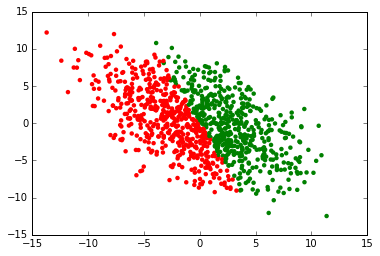

In [372]:
errors = 0

X_vis = vis_proj(X)
for i in range(X.shape[0]):
    N = logistic_regression_f(X[i,:], weights)
    pred = N.constant_cf
    
    if pred > 0.5:
            pred = 1
    else:
            pred = 0
    if pred == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
   
    if pred == y_f(X[i,::]):                
        errors +=1
        
print(errors*1.0/X.shape[0])        

We update the weights with gradient descent using the Hessian and the first order derivatives of the loss function with respect to the weights (and biases)

In [373]:
def hessian(loss, w):
    
    num_params = len(w)
    
    partials = np.zeros((num_params, num_params))

    for i in range(len(w)):
        for ii in range(len(w)):
            wi = w[i]
            wii = w[ii]
            if wi.symbol_set[0] in loss.symbol_set and wii.symbol_set[0] in loss.symbol_set:
                idx = loss.symbol_set.index(wi.symbol_set[0])
                iidx = loss.symbol_set.index(wii.symbol_set[0])
                dw_idx = [0]*loss.symbol_set_size                    
                dw_idx[idx] += 1
                dw_idx[iidx] += 1
                partial = loss.get_derivative(dw_idx)
            else:
                partial = 0

            partials[i,ii] = partial
    return partials#np.linalg.inv(partials)

In [374]:
weights = initialize_weights(n_inputs, order)                

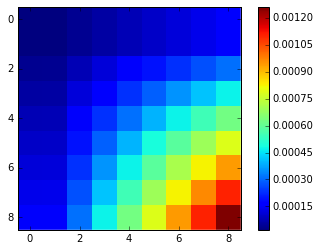

In [385]:
N = logistic_regression_f(x, weights)
loss = loss_f(N, y_f(x))
H = hessian(loss, weights)
plt.imshow(H, interpolation='none')
plt.colorbar()

In [400]:
def first_order_devs(loss, w):
    
    num_params = len(w)
    
    devs = np.zeros((num_params))

    for i in range(len(w)):
            if w[i].symbol_set[0] in loss.symbol_set:
                dw_idx = [0]*loss.symbol_set_size                    
                dw_idx[i] = 1
                d = loss.get_derivative(dw_idx)
            else:
                d = 0

            devs[i] = d
            
    return devs

In [401]:
first_derivs = first_order_devs(loss, weights)

In [409]:
def Newton_update(loss, w, lr):
    

    d = first_order_devs(loss, w)
    H = np.linalg.pinv(hessian(loss, w))
    
    updates = np.dot(H, d.reshape(-1,1))

    i=0
    for i in range(len(w)):
        w[i] -= updates[i]*lr
    
    return w

In [410]:
epochs = 20

for e in range(epochs):
    
        
    #Meassures the train accuracy
    acc = 0
    for xi in X_train:
        N = logistic_regression_f(xi, weights)
        pred = N.constant_cf
        if pred > 0.5:
            pred = 1
        else:
            pred = 0
        if pred == y_f(xi):
            acc += 1/X_train.shape[0]            
    print('Epoch {0}: accuracy {1}'.format(e, acc))    

    #Updates the weights
    for xi in X_train:
        N = logistic_regression_f(xi, weights)
        loss = loss_f(N, y_f(xi))           
        weights = Newton_update(loss, weights, 0.1)    


Epoch 0: accuracy 0.6974999999999961
Epoch 1: accuracy 0.702499999999996
Epoch 2: accuracy 0.6874999999999963
Epoch 3: accuracy 0.6624999999999969
Epoch 4: accuracy 0.6899999999999963
Epoch 5: accuracy 0.6849999999999964
Epoch 6: accuracy 0.6899999999999963
Epoch 7: accuracy 0.6899999999999963
Epoch 8: accuracy 0.6899999999999963
Epoch 9: accuracy 0.6874999999999963
Epoch 10: accuracy 0.6899999999999963
Epoch 11: accuracy 0.6924999999999962
Epoch 12: accuracy 0.6924999999999962
Epoch 13: accuracy 0.6924999999999962
Epoch 14: accuracy 0.7074999999999959
Epoch 15: accuracy 0.7074999999999959
Epoch 16: accuracy 0.7199999999999956
Epoch 17: accuracy 0.7149999999999958
Epoch 18: accuracy 0.7149999999999958
Epoch 19: accuracy 0.7149999999999958


0.735


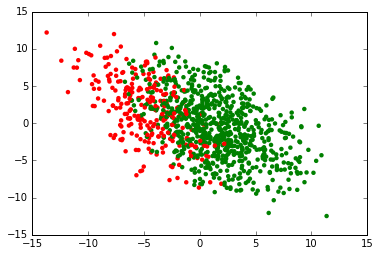

In [411]:
errors = 0

X_vis = vis_proj(X)
for i in range(X.shape[0]):
    N = logistic_regression_f(X[i,:], weights)
    pred = N.constant_cf
    
    if pred > 0.5:
            pred = 1
    else:
            pred = 0
    if pred == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
   
    if pred == y_f(X[i,::]):                
        errors +=1
        
print(errors*1.0/X.shape[0])        